<h1 style="text-align: center;">Hit Analyzer</h1>
<h2 style="text-align: center;">By: Thomas Giewont, Shreyas Vaidya, and Thomas Varano</h2>

<br>
<h3 style="text-align: center;">Introduction</h3>
<p> This is the Introduction. </p>

<h3 style="text-align: center;">Imports and Data Setup</h3>

In [244]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
import json

<h3 style="text-align: center;">Data Collection and Curation</h3>

In [245]:
df = pd.read_csv('https://query.data.world/s/aofqalvgkuabshmmlxm32rxk3t3yiq')

In [246]:
df = df.drop(columns=['url'])
df = df.rename(columns={'WeekID': 'week', 'Week Position': 'week_position', 'Song': 'song', 'Performer': 'performer', 'SongID': 'songid', 'Instance': 'instance', 'Previous Week Position': 'prev_week_position', 'Peak Position': 'peak_position', 'Weeks on Chart': 'weeks_on_chart'})

In [247]:
df = df.astype({"week": 'datetime64'})

In [248]:
# stuff after 2000... obvi remove
# df = df[df.week > pd.to_datetime(datetime.date(2000, 1, 1))]


In [249]:
# make a copy incase we fuck some data
dfcpy = df.copy()

In [250]:
# restore df
df = dfcpy.copy()

<h3 style="text-align: center;">Data Analysis</h3>

#### Hypothesis:
We believe that every song follows a similar trend when they reach the Billboard Top 100.

In [251]:
# remove weird nans
# tm = df.loc[:, df.columns != 'prev_week_position']
df = df.dropna(subset=['week', 'week_position', 'song', 'performer', 'songid', 'instance', 'peak_position', 'weeks_on_chart'])


In [252]:
# make dataframe to keep track of song-wide data

song_info = df.drop_duplicates(subset=['songid']).drop(columns=['week', 'week_position', 'instance', 'prev_week_position', 'peak_position', 'weeks_on_chart']).set_index('songid')

In [253]:
# only keep the songs that peaked in the top 10
df = df.drop(columns=['peak_position'])


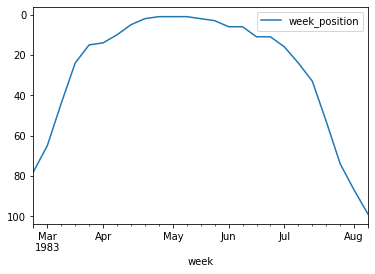

In [288]:
ax = plt.gca()
# for s in df.song.unique(): 
s = "Beat ItMichael Jackson"
df[df.songid == s].plot(x='week', y='week_position', ax = ax)
horiz_line_data = np.array([10 for i in range(len(df[df.songid == s]))])
plt.plot(df[df.songid == s].week, horiz_line_data, 'r') 
plt.gca().invert_yaxis()
# print(min(pk))

In [255]:
for s in df.songid.unique():
    song_instances = df[df.songid == s].sort_values(by='week')

    # remove all instances of the song that are more than 2 years out from the previous time on the charts
    indxs = song_instances.index.values
    lastPoint = 0
    for i in range(1, len(indxs)):
        if (song_instances.loc[indxs[i]].week - song_instances.loc[indxs[lastPoint]].week).days / 365 > 2: 
            df = df.drop(index=indxs[i])
            song_instances = song_instances.drop(index=indxs[i])
        else: 
            lastPoint += 1

In [256]:
# get the absolute peak for each song
for s in list(song_info.index.values): 
    song_info.at[s, 'peak'] = min(df[df.songid == s].week_position.unique())

df = df[[(song_info.loc[r.songid].peak <= 10) for _, r in df.iterrows()]]
song_info = song_info[song_info.peak <= 10]


In [257]:
# finding time before peak
# find when week_position == peak
# find the smallest weekid for my song
# subtract

# first hot week
# df.days_to_hot = np.nan


for s in df.songid.unique():

    song_instances = df[df.songid == s].sort_values(by='week')

    if len(song_instances[song_instances.week_position <= 10].week) != 0: 
        week = 1
        
        # get all peaks and their weeks
        # inflection points of graph in form: 
        # tuple (date, begin), where begin is true if the inflection point is beginning a hot spell
        inflections = []
        longest_peak = []

        # if the first week is already in the top 10
        if song_instances.iloc[0].week_position <= 10: 
            inflections.append((song_instances.iloc[0].week, True))


        for i in range(1, len(song_instances)): 
                
            if song_instances.iloc[i].week_position <= 10 and song_instances.iloc[i - 1].week_position > 10: 
                # this is for grace period
                if i > 1 and song_instances.iloc[i-2].week_position <= 10: 
                    # remove the last ending guy
                        inflections.remove(inflections[len(inflections) - 1])
                else: 
                    # if not beginning after a grace period, 
                    inflections.append((song_instances.iloc[i].week, True))
            elif song_instances.iloc[i].week_position > 10 and song_instances.iloc[i - 1].week_position <= 10:
                inflections.append((song_instances.iloc[i - 1].week, False))
   
        # if the song finished in the top 10 and dropped off the charts
        if song_instances.iloc[len(song_instances) - 1].week_position <= 10: 
            inflections.append((song_instances.iloc[len(song_instances) - 1].week, False))

        for i in range(0, len(inflections)-1):
            longest_date = datetime.timedelta(0)
            if len(inflections) == 0 or len(inflections) == 1:
                longest_peak = inflections
            else:
                if inflections[i][1] is True and inflections[i+1][1] is False:
                    if inflections[i+1][0] - inflections[i][0] >= longest_date:
                        longest_date = inflections[i+1][0] - inflections[i][0]
                        longest_peak = []
                        longest_peak.append(inflections[i])
                        longest_peak.append(inflections[i+1])

            # longest peak is relevant peak we care about

        song_info.loc[s, 'start_week'] = min(song_instances.week)
        song_info.loc[s, 'end_week'] = max(song_instances.week)
        song_info.loc[s, 'start_peak'] = longest_peak[0][0]
        song_info.loc[s, 'end_peak'] = longest_peak[1][0]
        
                

In [258]:
# note we had to deal with prince popping back up on the charts after he died (and we might be dead by tomorrowsoko)
# dealt with those weirdly
# and then also guys that peaked one week and dipped

In [259]:
# make weeks to hot and weeks hot

for i, r in song_info.iterrows(): 
    song_info.loc[i, 'weeks_to_hot'] = (r.start_peak - r.start_week).days / 7
    song_info.loc[i, 'weeks_hot'] = (r.end_peak - r.start_peak).days / 7 + 1
    song_info.loc[i, 'tail_weeks'] = (r.end_week - r.end_peak).days / 7

song_info = song_info.astype({"weeks_to_hot": 'float', "weeks_hot": 'float', "tail_weeks": 'float'})


In [260]:
for i, r in df.iterrows(): 
    df.at[i, 'rel_week'] = (r.week - song_info.loc[r.songid, 'start_week']).days / 7

In [261]:
# save df
df.to_csv("dfSave.csv")

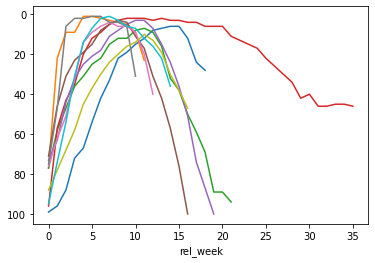

In [262]:
# a couple graphs to make pretty and look at
sngs = song_info.sample(n=10).index.values
ax = plt.gca()
tmp = df.sort_values(by='week')
for s in sngs: 
    tmp[tmp.songid == s].plot(x='rel_week', y='week_position', ax=ax)
plt.gca().invert_yaxis()
ax.get_legend().remove()
plt.show()

In [263]:
# More data points 

for s in df.songid.unique(): 
    song_inst = df[df.songid == s]

    # time above 10 total
    song_info.at[s, 'time_at_top_10'] = len(song_inst[song_inst.week_position <= 10])

    # slope of the climb
    # abs(start_peak position - start_week position)
    pos_climbed = abs(int(song_inst[song_inst.week == song_info.loc[s, 'start_peak']].week_position) - int(song_inst[song_inst.week == song_info.loc[s, 'start_week']].week_position))
    # if the song started on the chart, make the slope -1. else, make it (how many positions it climbed) / (how long the climb was)
    song_info.loc[s, 'climb_slope'] = -1 if song_info.loc[s, 'weeks_to_hot'] == 0 else (pos_climbed/song_info.loc[s, 'weeks_to_hot'])

    # slope of the tail (-1 if it just fell off the charts)
    # abs(end_peak position - end_week position)
    pos_lost = abs(int(song_inst[song_inst.week == song_info.loc[s, 'end_peak']].week_position) - int(song_inst[song_inst.week == song_info.loc[s, 'end_week']].week_position))
    song_info.loc[s, 'tail_slope'] = -1 if song_info.loc[s, 'tail_weeks'] == 0 else (pos_lost/song_info.loc[s, 'tail_weeks'])

    # average value
    song_info.at[s, 'avg_position'] = song_inst.week_position.mean()

    # weeks on chart
    song_info.at[s, 'weeks_on_chart'] = max(song_inst.weeks_on_chart)

    # instance
    song_info.at[s, 'instance'] = max(song_inst.instance)
song_info



In [264]:
df.insert(loc=len(df.columns), column='jump', value=[r.week_position - r.prev_week_position for _, r in df.iterrows()])

array([<AxesSubplot:title={'center':'jump'}>], dtype=object)

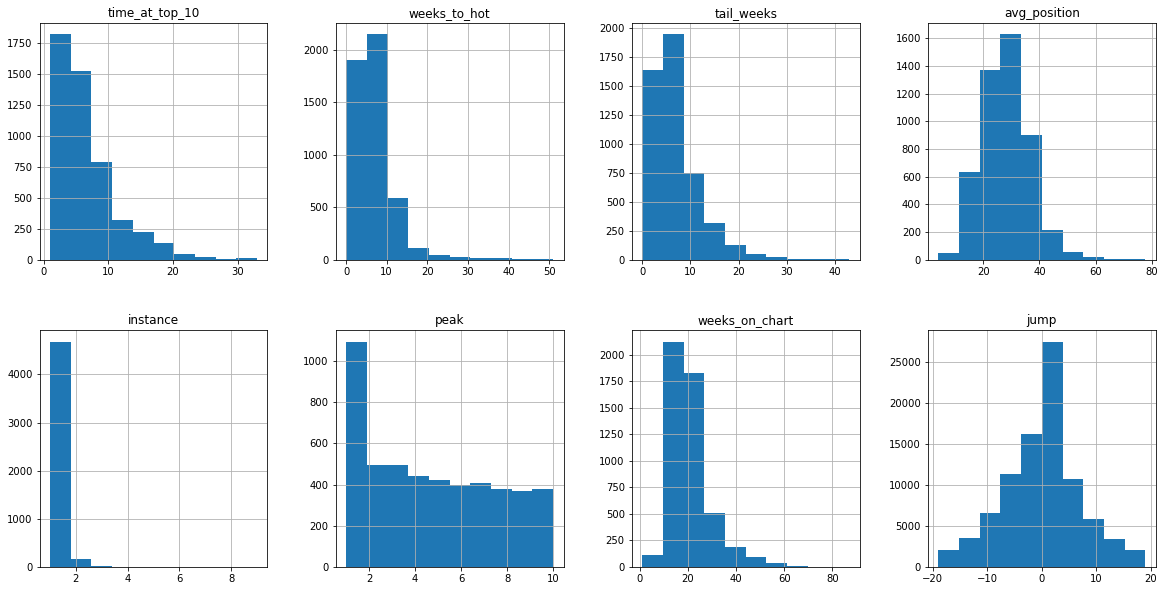

In [293]:
fig, axs = plt.subplots(2,4,figsize=(20,10))

song_info.hist('time_at_top_10', ax=axs[0, 0])
song_info[song_info.weeks_to_hot < 52].hist('weeks_to_hot', ax=axs[0, 1])
song_info[song_info.tail_weeks < 52].hist('tail_weeks', ax=axs[0, 2])
song_info.hist('avg_position', ax=axs[0, 3])
song_info.hist('instance', ax=axs[1, 0])
song_info.hist('peak', ax=axs[1, 1])
song_info.hist('weeks_on_chart', ax=axs[1, 2])
df[abs(df.jump) < 20].hist('jump', ax=axs[1, 3])


In [267]:
train = song_info.copy()[['peak', 'weeks_on_chart', 'weeks_hot', 'weeks_to_hot', 'instance', 'tail_weeks' ]]
train = train.reset_index().drop(columns=['songid'])

4883

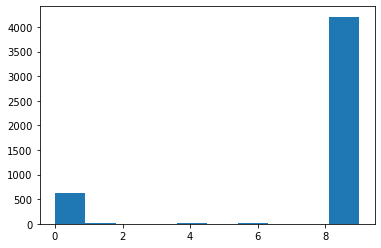

In [277]:
#Sets a random state so we get the same results every time
random_state = 170
#for now 
model = KMeans(n_clusters=10, random_state = random_state)
model.fit(train.to_numpy())
all_predictions = model.predict(train.to_numpy())
plt.hist(all_predictions)
len(all_predictions)

In [281]:
song_info.drop(columns=['group'], inplace=True)

In [282]:
#assigns the cluster number to the train dataframe for each corresponding song
# for i,r in train.iterrows():
song_info.insert(len(song_info.columns), "group", all_predictions)

In [283]:
#Gets averages for every cluster/group. This code is definitely not the most efficient way and I will probably redo
class Result:
    def __init__(self,peak, wc, wh, wth, inst, tail, group):
        self.peak = peak
        self.wc = wc
        self.wh = wh
        self.wth = wth
        self.inst = inst
        self.tail = tail
        self.group = group
        self.len = 1
    def add(self,peak, wc, wh, wth, inst, tail):
        self.peak += peak
        self.wc += wc
        self.wh += wh
        self.wth += wth
        self.inst += inst
        self.tail += tail
        self.len += 1
    def get(self):
        return {
            "peak": self.peak / self.len,
            "weeks_on_chart": self.wc / self.len,
            "weeks_hot" : self.wh / self.len,
            'weeks_to_hot' : self.wth / self.len,
            'instance' : self.inst / self.len,
            'tail_weeks' : self.tail / self.len,
            'group' : self.group,
            'length' : self.len
        }
    def display(self):
        v = self.get()
        return json.dumps(v)
cluster = {}
for i,r in song_info.iterrows():
    key = r.group
    if key in cluster:
        cluster[key].add(r.peak, r.weeks_on_chart, r.weeks_hot, r.weeks_to_hot, r.instance, r.tail_weeks)
    else:
        temp = Result(r.peak, r.weeks_on_chart, r.weeks_hot, r.weeks_to_hot, r.instance, r.tail_weeks, key)
        cluster[key] = temp

for c in cluster:
    print(cluster[c].display())

{"peak": 4.795152091254753, "weeks_on_chart": 18.01235741444867, "weeks_hot": 5.640209125475285, "weeks_to_hot": 6.468393536121673, "instance": 1.0121197718631179, "tail_weeks": 5.957699619771863, "group": 9, "length": 4208}
{"peak": 4.0015772870662465, "weeks_on_chart": 37.33280757097792, "weeks_hot": 11.613564668769715, "weeks_to_hot": 16.52365930599369, "instance": 1.222397476340694, "tail_weeks": 16.165615141955836, "group": 0, "length": 634}
{"peak": 5.0, "weeks_on_chart": 30.0, "weeks_hot": 26.5, "weeks_to_hot": 3107.0, "instance": 8.5, "tail_weeks": 0.0, "group": 3, "length": 2}
{"peak": 4.0, "weeks_on_chart": 23.5, "weeks_hot": 8.0, "weeks_to_hot": 5.875, "instance": 2.0, "tail_weeks": 504.625, "group": 4, "length": 8}
{"peak": 2.3333333333333335, "weeks_on_chart": 25.333333333333332, "weeks_hot": 2.0, "weeks_to_hot": 1550.6666666666667, "instance": 2.0, "tail_weeks": 2.3333333333333335, "group": 2, "length": 3}
{"peak": 3.1666666666666665, "weeks_on_chart": 28.166666666666668,

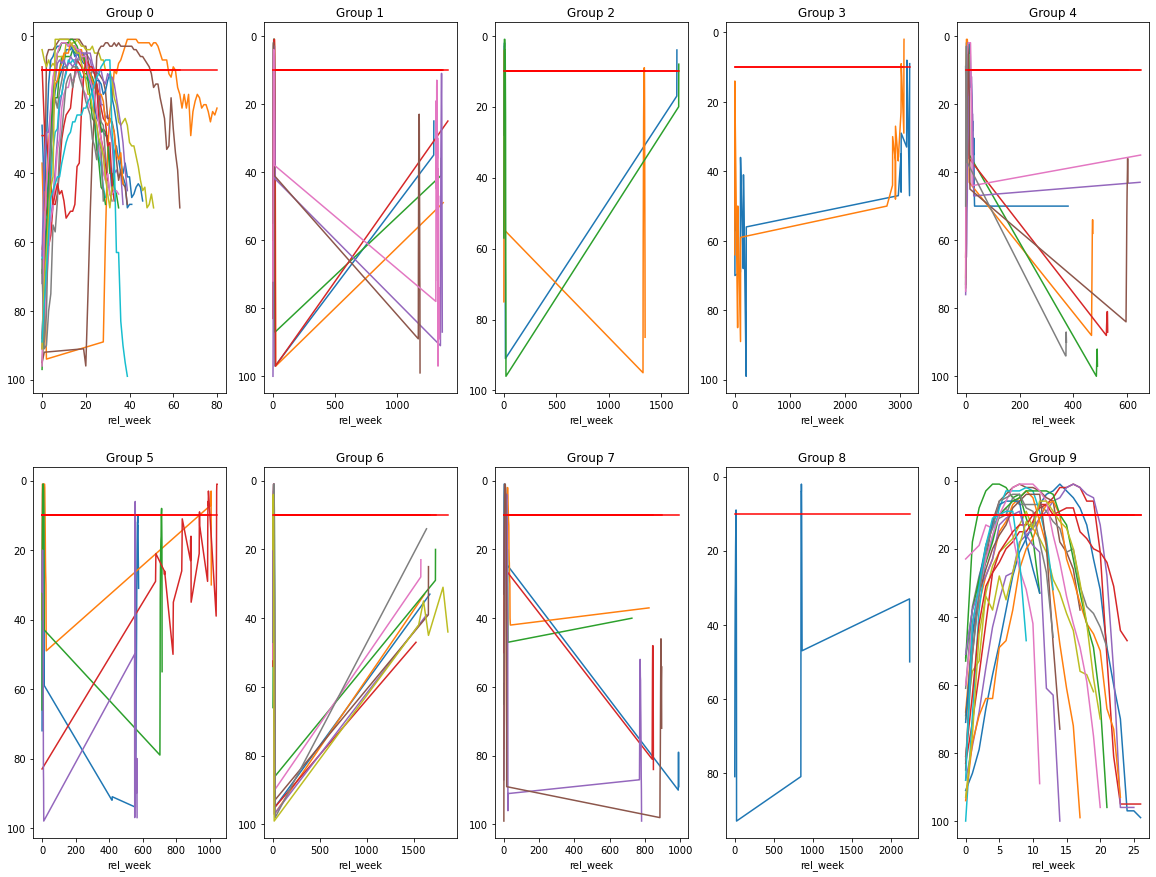

In [284]:
from random import sample
frames = {}
fig, axs = plt.subplots(1,5,figsize=(20,15))
for c in sorted(cluster):
    temp = song_info[song_info.group == c].index.values
    if len(temp) > 20:
        temp = sample(temp.tolist(),20)
    df = df.sort_values(by='week')
    for s in temp:
        df[df.songid == s].plot(x='rel_week', y='week_position', ax = axs[c//5, c%5])
        horiz_line_data = np.array([10 for i in range(len(df[df.songid == s]))])
        axs[c//5, c%5].plot(df[df.songid == s].rel_week, horiz_line_data, 'r') 
    axs[c//5, c%5].invert_yaxis()
    axs[c//5, c%5].get_legend().remove()
    axs[c//5, c%5].title.set_text("Group " + str(c))


In [285]:
song_info[song_info.group == 9]
#NOTE lucid dreams has the wrong peak chosen!


,song,performer,peak,start_week,end_week,start_peak,end_peak,weeks_to_hot,weeks_hot,tail_weeks,time_at_top_10,climb_slope,tail_slope,avg_position,weeks_on_chart,instance,group
songid,,,,,,,,,,,,,,,,,
StillBill Anderson,Still,Bill Anderson,8.0,1963-04-13,1963-07-20,1963-06-08,1963-06-22,8.0,3.0,4.0,3.0,11.375000,7.000000,34.066667,15.0,1.0,9
Saturday NightBay City Rollers,Saturday Night,Bay City Rollers,1.0,1975-10-11,1976-01-31,1975-12-06,1976-01-10,8.0,6.0,3.0,6.0,9.500000,15.333333,27.588235,17.0,1.0,9
Pop MuzikM,Pop Muzik,M,1.0,1979-08-11,1980-01-19,1979-10-06,1979-12-01,8.0,9.0,7.0,9.0,6.625000,12.857143,25.208333,24.0,1.0,9
CarrieEurope,Carrie,Europe,3.0,1987-08-01,1987-12-05,1987-09-26,1987-10-24,8.0,5.0,6.0,5.0,8.125000,15.000000,35.736842,19.0,1.0,9
CasanovaLevert,Casanova,Levert,5.0,1987-08-15,1987-12-12,1987-10-10,1987-10-31,8.0,4.0,6.0,4.0,10.000000,15.166667,34.666667,18.0,1.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
You Haven't Done NothinStevie Wonder,You Haven't Done Nothin,Stevie Wonder,1.0,1974-08-03,1974-12-07,1974-09-21,1974-11-02,7.0,7.0,5.0,7.0,12.000000,18.400000,27.421053,19.0,1.0,9
You Keep Me Hangin' OnKim Wilde,You Keep Me Hangin' On,Kim Wilde,1.0,1987-03-28,1987-08-15,1987-05-16,1987-06-20,7.0,6.0,8.0,6.0,12.571429,11.000000,38.333333,21.0,1.0,9
You Keep Me Hangin' OnThe Supremes,You Keep Me Hangin' On,The Supremes,1.0,1966-10-29,1967-01-14,1966-11-12,1966-12-17,2.0,6.0,4.0,6.0,30.500000,11.250000,17.750000,12.0,1.0,9


In [274]:
df[df.rel_week > 100]


,week,week_position,song,performer,songid,instance,prev_week_position,weeks_on_chart,rel_week,jump
171520,1960-12-10,69,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,2.0,NaN,5.0,103.0,NaN
171804,1960-12-17,46,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,2.0,69.0,6.0,104.0,-23.0
197188,1960-12-24,36,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,2.0,46.0,7.0,105.0,-10.0
201404,1961-12-09,68,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,3.0,NaN,8.0,155.0,NaN
201444,1961-12-16,58,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,3.0,68.0,9.0,156.0,-10.0
...,...,...,...,...,...,...,...,...,...,...
201981,2019-12-28,15,It's The Most Wonderful Time Of The Year,Andy Williams,It's The Most Wonderful Time Of The YearAndy W...,4.0,20.0,13.0,155.0,-5.0
318055,2019-12-28,6,A Holly Jolly Christmas,Burl Ives,A Holly Jolly ChristmasBurl Ives,4.0,10.0,13.0,155.0,-4.0
318231,2019-12-28,1,All I Want For Christmas Is You,Mariah Carey,All I Want For Christmas Is YouMariah Carey,9.0,1.0,35.0,1042.0,0.0
202112,2019-12-28,9,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8.0,15.0,29.0,3184.0,-6.0


<AxesSubplot:xlabel='rel_week', ylabel='week_position'>

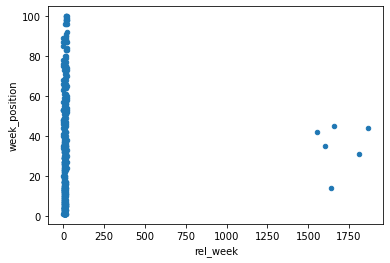

In [286]:
df[df.performer == 'Michael Jackson'].plot(x='rel_week', y='week_position', kind='scatter')

<h3 style="text-align: center;">Insights Attained</h3>